# HaMLeT

## Session 5: Neural Networks
by Raphael Kolk

### Goal of this Session

In this session you will, step by step, implement a neural network yourself without using any deep learning libraries. You should already be familiar with Python as well as NumPy (a package for scientific computing with Python).

### Tasks

**Task 0:** Please execute the following cell which is a workaround for data loading and ignore it until further notice.

In [25]:
from sklearn.metrics import accuracy_score 
from six.moves import urllib
class MNIST:
    def __init__(self):
        # Alternative method to load MNIST, if mldata.org is down
        from scipy.io import loadmat
        import os
        mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
        dset_path = os.path.join(os.path.abspath(os.environ["HOME"]), 'datasets')
        if not os.path.isdir(dset_path):
            os.makedirs(dset_path)
        mnist_path = os.path.join(dset_path, "mnist-original.mat")
        response = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_path, "wb") as f:
            content = response.read()
            f.write(content)
        mnist_raw = loadmat(mnist_path)
        self.data = mnist_raw["data"].T
        self.target = mnist_raw["label"][0]

**Task 1a:** Implement the sigmoid function! Make sure it can handle a vector of values.

In [2]:
import numpy as np

def sigmoid(z):
    # ---------- Add code in between these comments ----------
    sig = []
    sig = 1./(1 + np.exp(-z))
    return sig
# --------------------------------------------------------

**Task 1b:** For later use in the backpropagation algorithm calculate the first derivative of the sigmoid function and implement it.

In [3]:
def sigmoid_derivative(z):
    # ---------- Add code in between these comments ----------
    a = sigmoid(z)
    deriv_sig = np.multiply(a,1-a)
    return deriv_sig
z = np.array([-1000, -100, 0, 10, 1000])
print(sigmoid_derivative(z))
    # --------------------------------------------------------

[0.00000000e+00 3.72007598e-44 2.50000000e-01 4.53958077e-05
 0.00000000e+00]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


**Task 1c:** Plot the implemented sigmoid function and its dericative by executing the next cell to ensure that it works properly!

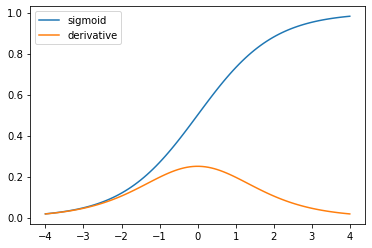

In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt

x = np.linspace(-4, 4, num=100)
plt.plot(x, sigmoid(x))
plt.plot(x, sigmoid_derivative(x))
plt.legend(("sigmoid", "derivative"))
plt.show()

The centerpiece is the `Network` class which we use to represent a neural network. The following cell starts to implement the network object by defining the `__init__(self, ...)` method that is the constructor of the class and initializes the member variables. The biases and weights in the Network object are all initialized randomly using a Gaussian distribution with mean 0 and standard deviation 1. This random initialization gives our stochastic gradient descent algorithm a place to start from.

The list `sizes`, which contains the number of neurons in the respective layers of the network, is given as a parameter.  For example, if the list was `[2, 3, 1]`, then it would be a three-layer network with the first layer containing 2 neurons, the second layer 3 neurons, and the third layer 1 neuron. 

After initialization the class instance should contain the following four member variables:

- **`self.num_layers`** is the total number of layers in the network.

- **`self.sizes`** is the same as the parameter `sizes`.

- **`self.biases`** is a list of NumPy vectors. The biases for each hidden and output layer are stored in the respective vector of the list. The biases for the network are initialized randomly, using a Gaussian distribution with mean 0 and variance 1. Note that the first layer is assumed to be an input layer, and by convention we won't set any biases for those neurons, since biases are only ever used in computing the outputs from preceding layers.

- **`self.weights`** is a list of NumPy matrices, each storing the weights of the connection between layers. So for example `self.weights[1]` is a NumPy matrix storing the weights connecting the second and third layers of neurons. (It's not the first and second layers, since Python's list indexing starts at 0.) Since `self.weights[1]` is rather verbose, let's just denote that matrix $w$. It's a matrix such that $w_{jk}$ is the weight for the connection between the $k$-th neuron in the second layer, and the $j$-th neuron in the third layer. 

To generate random values you are supposed to use the NumPy function `np.random.randn()`. Look up the NumPy documentation for further information on the usage.

**Task 2a:** Implement the code initializing the four member variables of the network!


In [53]:
import jdc # import for jupyter magic command "%%add_to".
import random

class Network(object):

    def __init__(self, sizes):
        """Initialize network with random weights and biases."""
        # ---------- Add code in between these comments ----------
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = np.random.randn(self.num_layers-1,1)
        #self.biases[0][0] = 0
        self.weights = [None]*(len(sizes) - 1)
        for i in range(self.num_layers - 1):
            self.weights[i] = np.random.randn(sizes[i+1],sizes[i])
        # --------------------------------------------------------
        
    def __str__(self):
        """String representation of class"""
        return "Number of layers: " + str(self.num_layers) + "\n" + \
               "Sizes of layers: " + str(self.sizes) + "\n" + \
               "Biases:" + "\n" + "\n".join([str(s) for s in self.biases]) + "\n" + \
               "Weights:" + "\n" + "\n".join([str(s) for s in self.weights])
    
    

**Task 2b:** In order to verify your implementation, initialize a new `Network` with an input layer of 3 neurons, two hidden layers with 4 neurons each and an output layer of 2 neurons.

In [6]:
# ---------- Add code in between these comments ----------
net = Network([3,4,4,2]) 
# --------------------------------------------------------
print(net)


2
Number of layers: 4
Sizes of layers: [3, 4, 4, 2]
Biases:
[0.43126681]
[-1.29976136]
[0.06345263]
Weights:
[[ 0.75453061 -0.04869302 -0.00432579]
 [-1.44400639 -1.12403455  2.11985618]
 [ 0.65513264 -0.70530802  0.76531734]
 [-0.40318342  0.07792624  0.73881814]]
[[-0.64918183  0.57428202  0.29890401  0.19307467]
 [ 0.15291758 -0.28302736  1.25309472 -1.16080474]
 [ 1.61720973  0.69807792  1.2229426  -0.76262886]
 [-1.19480338 -1.80690477 -1.60028249  0.55619578]]
[[-0.8034053  -0.59310429 -0.77191979 -0.11525307]
 [-0.1186639  -0.89870342  0.30479274  0.83304261]]


As mentioned above the weight matrix `self.weights[1]` denoted as $w$ stores the weights such that $w_{jk}$ is the weight for the connection between the $k$-th neuron in the second layer and the $j$-th neuron in the third layer
This ordering of the $j$ and $k$ indices may seem strange - surely it would make more sense to swap the j and k indices around? The big advantage of using this ordering is that it means the vector of activations of the third layer of neurons is:

$$a'=\sigma(wa+b)$$

**Task 3a:** Using the earlier implemented `sigmoid()` function implement the `feed_forward()` method, which applies the equation stated above layer by layer to a given input vector `a`.

Using the built-in `zip()` iterator helps you keep your code cleaner and thereby easier to understand.

In [7]:
%%add_to Network
def feed_forward(self, a):
    """Return the output of the network if ``a`` is input."""
    # ---------- Add code in between these comments ----------
    
    for i,j in zip(self.weights,list(self.biases)):
        a = sigmoid(np.matmul(i, a) + j)
        #print(i,  "i" , j, "j")
    return a
    
    # --------------------------------------------------------

**Task 3b:** In order to verify your implementation feed the randomly initialized network from task 2b the input vector `[1.2, 3.4, 5.6]`.

In [8]:
input = np.array([1.2, 3.4, 5.6]).reshape((-1, 1))
print(net.feed_forward(input))

[[0.29250528]
 [0.52004111]]


Now we are having a look at the actual training and validation dataset, which was introduced in the preparation material. 

Using scikit-learn we can easily import the MNIST dataset. After loading, images and labels are accessible in two `numpy.ndarrays`.

- Each of the 70000 rows in `mnist.data` stores one image (28 x 28 pixel) of a handwritten digit as a vector with a length of 784.

- `mnist.target` stores the corresponding labels as an integer number.

**Task 4a:** To familiarize yourself with the data, extract and plot ten different images of each digit (0 - 9).

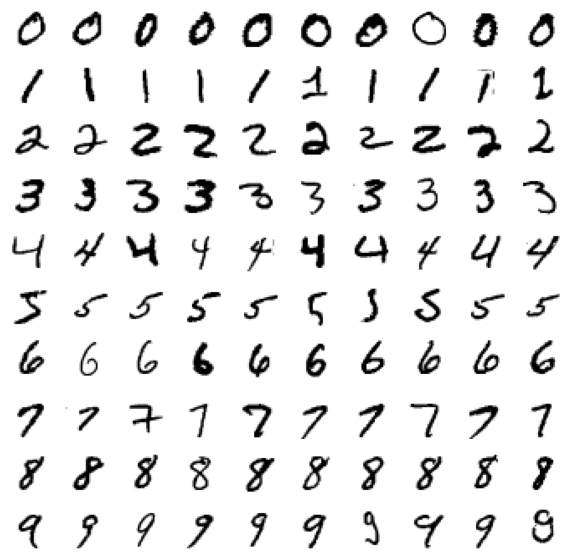

In [9]:
mnist = MNIST()

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))

for i in range(0, 10):
    ind = np.where(mnist.target == i)
    #print(type(mnist.target))
    for j in range (0, 10):
        # ---------- Add code in between these comments ----------
        b = ind[0][j]
        image = (mnist.data[b]).reshape(28,28)    
            
        
        # --------------------------------------------------------
        plt.subplot(10, 10, 10*i+j+1)
        plt.imshow(image, cmap='gist_yarg')
        fig.axes[10*i+j].set_axis_off()
        
plt.show()

Since we want to design our network with 10 output neurons and train it in a way that the output activation for the digit j becomes 1.0 at the j-th neuron, we need to vectorize our label.

**Task 4b:** Implement the function `vectorize()` which accepts an integer $j$ between 0 and 9 and returns a 10-dimensional unit vector with a 1.0 in the $j$-th position and zeroes elsewhere.  This is used to convert a digit (0...9) into a corresponding desired output from the neural network.

In [10]:
def vectorize(j):
    # ---------- Add code in between these comments ----------
    arr = np.zeros((10,))
    arr[j] = 1
    return arr
    # --------------------------------------------------------
    
print(vectorize(3))


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


We need to load and prepare the MNIST dataset to be used in the training of our network. Therefore the following steps need to be taken:

1. Load the data as we did in task 4a and convert images and labels into lists of samples. This is already implemented in the function below.

2. The images in the dataset are integer-valued with a maximum intensity of 255. Before feeding them to the input neuron we have to ensure that their pixel values are between 0.0 and 1.0.

3. The labels in the dataset are integers, so we need to vectorize them using the function implemented above.

4. We have to merge the list of images and the list of labels so that we end up with one list of tuples. Each tuple contains one image and one label.

5. The list of tuples needs to be split into `training_data` (60000 samples) and `validation_data` (10000 samples).

**Task 4c:** Implement steps 2 to 5 in the function below.

In [ ]:

def load_data():
    mnist = MNIST()
    images = [i.reshape((784,1)) for i in mnist.data]
    labels = [int(l) for l in mnist.target]
    
    # ---------- Add code in between these comments ----------
    images = [image.ravel()/255.0 for image in images]
    
    #for i in range(len)
    labels = [vectorize(label) for label in labels]
    
    tup = zip(images, labels)
    tus = list(tup)
    #print(tus[5])
    
    np.random.shuffle(tus)
    training_data, validation_data = tus[:60000], tus[60000:]
    #print(len(training_data), "xxxxxx", len(validation_data), "yyyyyy")
    # --------------------------------------------------------
    
    return training_data, validation_data

training_data, validation_data = load_data()

After each training epoch the performance of the network is evaluated by feeding the validation data into the network and comparing the output to the ground truth label. The neural network's output is assumed to be the index of the neuron with the highest activation in the output layer.

**Task 5a:** Implement the class method `evaluate()`, which feeds the network the validation data sample by sample using the `feed_forward()` method and return the number of correct classifications.

In [55]:
%%add_to Network
def evaluate(self, validation_data):
    # ---------- Add code in between these comments ----------
    outputs_from_model = [feed_forward(self , validation_data_ele[0]) for validation_data_ele in validation_data]
    targets = [validation_data_ele[1] for validation_data_ele in validation_data]
    accurate_count = 0
    for i in range(len(targets)):
        target_val = np.argmax(targets[i])
        output_val = np.argmax(outputs_from_model[i])
#         print(target_val, output_val)
        if target_val == output_val:
            accurate_count +=1
        
#         if np.logical_and(targets[i],outputs_from_model[i]):
#             accurate_count +=1
#     accuracy = sklearn.metrics.accuracy_score(targets, outputs_from_model)
    #for i in range(len(targets)):
#     accuracy = accurate_count / len(targets)
    return accurate_count    
    # --------------------------------------------------------

**Task 5b:** Test your implemented code by applying the method to a randomly initialized and untrained network. Since the odds for guessing correctly are 1 to 10 the evaluation output should be roughly 10%. You can execute the code several times to test the assumption.

In [56]:
training_data, validation_data = load_data()
net = Network([784, 30, 10])
print("Correct classifications of randomly initialized network: {0} of {1}".format(net.evaluate(validation_data), len(validation_data)))

Correct classifications of randomly initialized network: 1458 of 10000


The `train()` method, as its name implies, trains our network. The modification of the the `weights` and `biases` itself is done by the already implemented function `update_mini_batch()`, which again uses the backpropagation algorithm to calculate the gradient.

However, the `train()` method implements the stochastic gradient descent, which means that the gradient is calculated for a subset of training samples, a so called mini batch, rather than for the whole training set. Besides having other advantages this is a lot faster and shortens the time needed for training. After the network has been fed the training set, split into mini batches, and the parameters have been updated accordingly, the process is repeated in the next epoch, thereby iteratively tuning the network parameters to a near-optimal state.

In our implementation of the `train()` method the following steps need to be taken:
- The training and validation data is given formatted as described and impemented in task 4c.
- For every epoch (the number of epochs is given by `num_epochs`):
    - The order of the training data is randomly shuffled.
    - The training dataset is split into mini batches of the size `mini_batch_size`.
    - The `update_mini_batch()` method is applied to each mini batch.
    - The network's perfomance is evaluated and displayed.
    
**Task 6a:** Implement the missing code in the `train()` method as described above.

In [89]:
%%add_to Network
def train(self, training_data, validation_data, num_epochs, mini_batch_size, learning_rate):
    for j in range(num_epochs):
        # ---------- Add code in between these comments ----------
        np.random.shuffle(training_data)
        mini_batch_data = training_data[:mini_batch_size]
        update_mini_batch(self,mini_batch_data, learning_rate)
    print("Correct classifications of randomly initialized network: {0} of {1}".format(self.evaluate(validation_data), len(validation_data)))
        # --------------------------------------------------------

def update_mini_batch(self, mini_batch, learning_rate):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [w-(learning_rate/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(learning_rate/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

def backpropagation(self, x, y):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
#     print(nabla_b.shape, nabla_w.shape)
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(self.biases, self.weights):
        print("ssss")
        z = np.dot(w, activation)+b
        print("dddd")
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    # backward pass
#     print("here")
    delta = (activations[-1] - y) * sigmoid_derivative(zs[-1]) #delta = 100 values
    print(delta.shape)
    print("here2")
    nabla_b[-1] = delta
#     print(delta)
    print("delta.shape",delta,activations[-2].transpose())
    print(activations[-2].shape, "RESHMAAAA")
    
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) #10 z values and 10 data per epoch 10x10= delta 
    
    print("here3")
    for l in range(2, self.num_layers):
        z = zs[-l]
        sp = sigmoid_derivative(z)
        delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    return (nabla_b, nabla_w)

Using all the implemented functionality above you can finally train a network on the MNIST dataset. Therefore:
- Load the training and validation data.
- Instantiate a new network with
    - 784 neurons in the input layer,
    - 30 neurons in the first and only hidden layer and
    - 10 neurons in the output layer.
- Train the network using the training and validation data
    - for 30 epochs,
    - with a mini batch size of 10 and
    - a learning rate of 3.0.
    
**Task 6b:** Implement the training process as stated above.

In [87]:
# ---------- Add code in between these comments ----------
train(net, training_data, validation_data, 40, 20, 3.0)
# --------------------------------------------------------

ssss
dddd
ssss
dddd
(10,)
here2
delta.shape [ 2.07194981e-03  6.00713747e-03  1.46502342e-01  1.46020918e-01
  1.08748466e-03  7.01883304e-03  2.87694088e-03 -9.93845547e-02
  2.79887933e-02  5.16323462e-05] [0.9999843  0.99999998 0.2887328  0.98139208 0.96575737 0.16694595
 0.33883821 0.98040198 0.99997708 0.04387273 0.74791221 0.00224315
 0.4045613  0.78078406 0.01231828 0.03402619 0.99997756 0.00268362
 0.07957649 0.01854375 0.87206979 0.96299681 0.37993192 0.87328011
 0.99224665 0.07555197 0.99876036 0.9830746  0.10474936 0.00513296]


ValueError: shapes (10,) and (30,) not aligned: 10 (dim 0) != 30 (dim 0)

**Task 7:** Have fun changing the training parameters or the design of the network and observing the resulting classification rate.

In [ ]:
# ---------- Add code in between these comments ----------
# --------------------------------------------------------

### Feedback

Aaaaaand we're done 👏🏼🍻

If you have any suggestions on how we could improve this session, please let us know in the following cell. What did you particularly like or dislike? Did you miss any contents?

### Additional Tasks

**Task 8:** Expand your `train` function by a learning rate decay / scheduler.

In [ ]:
# ---------- Add code in between these comments ----------
# --------------------------------------------------------